In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import linear_model
from sklearn.utils import shuffle
from sklearn.svm import SVR


from xgboost import XGBRegressor

In [ ]:
df = pd.read_csv("/content/DatasetAfricaMalaria.csv")
df.head()

,Country Name,Year,Country Code,"Incidence of malaria (per 1,000 population at risk)",Malaria cases reported,Use of insecticide-treated bed nets (% of under-5 population),Children with fever receiving antimalarial drugs (% of children under age 5 with fever),Intermittent preventive treatment (IPT) of malaria in pregnancy (% of pregnant women),People using safely managed drinking water services (% of population),"People using safely managed drinking water services, rural (% of rural population)","People using safely managed drinking water services, urban (% of urban population)",People using safely managed sanitation services (% of population),"People using safely managed sanitation services, rural (% of rural population)","People using safely managed sanitation services, urban (% of urban population)",Rural population (% of total population),Rural population growth (annual %),Urban population (% of total population),Urban population growth (annual %),People using at least basic drinking water services (% of population),"People using at least basic drinking water services, rural (% of rural population)","People using at least basic drinking water services, urban (% of urban population)",People using at least basic sanitation services (% of population),"People using at least basic sanitation services, rural (% of rural population)","People using at least basic sanitation services, urban (% of urban population)",latitude,longitude,geometry
0,Algeria,2007,DZA,0.01,26.0,NaN,NaN,NaN,NaN,NaN,NaN,18.24,19.96,17.33,34.65,-0.60,65.35,2.71,91.68,85.83,94.78,85.85,76.94,90.57,28.033886,1.659626,POINT (28.033886 1.659626)
1,Angola,2007,AGO,286.72,1533485.0,18.0,29.8,1.5,NaN,NaN,NaN,NaN,NaN,NaN,42.48,1.91,57.52,5.01,47.96,23.77,65.83,37.26,14.00,54.44,-11.202692,17.873887,POINT (-11.202692 17.873887)
2,Benin,2007,BEN,480.24,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58.44,1.99,41.56,4.09,63.78,54.92,76.24,11.80,4.29,22.36,9.307690,2.315834,POINT (9.307689999999999 2.315834)
3,Botswana,2007,BWA,1.03,390.0,NaN,NaN,NaN,NaN,NaN,83.96,NaN,NaN,NaN,42.07,-1.44,57.93,4.80,78.89,57.60,94.35,61.60,39.99,77.30,-22.328474,24.684866,POINT (-22.328474 24.684866)
4,Burkina Faso,2007,BFA,503.80,44246.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.00,2.16,23.00,5.91,52.27,45.13,76.15,15.60,6.38,46.49,12.238333,-1.561593,POINT (12.238333 -1.561593)


## inspecting the dataset


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594 entries, 0 to 593
Data columns (total 27 columns):
 #   Column                                                                                   Non-Null Count  Dtype  
---  ------                                                                                   --------------  -----  
 0   Country Name                                                                             594 non-null    object 
 1   Year                                                                                     594 non-null    int64  
 2   Country Code                                                                             594 non-null    object 
 3   Incidence of malaria (per 1,000 population at risk)                                      550 non-null    float64
 4   Malaria cases reported                                                                   550 non-null    float64
 5   Use of insecticide-treated bed nets (% of under-5 population)   

In [ ]:
# dropping unnecessary columns geometry
df = df.drop(['geometry'],axis=1)
# df = df.drop(df.columns[[geometry,Country Code,Country Name]],axis = 1,inplace = True)




In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594 entries, 0 to 593
Data columns (total 26 columns):
 #   Column                                                                                   Non-Null Count  Dtype  
---  ------                                                                                   --------------  -----  
 0   Country Name                                                                             594 non-null    object 
 1   Year                                                                                     594 non-null    int64  
 2   Country Code                                                                             594 non-null    object 
 3   Incidence of malaria (per 1,000 population at risk)                                      550 non-null    float64
 4   Malaria cases reported                                                                   550 non-null    float64
 5   Use of insecticide-treated bed nets (% of under-5 population)   

In [ ]:
# replacing the missing values
insecticide = df['Use of insecticide-treated bed nets (% of under-5 population)'].median()
childfever = df['Children with fever receiving antimalarial drugs (% of children under age 5 with fever)'].median()
treatment = df['Intermittent preventive treatment (IPT) of malaria in pregnancy (% of pregnant women)'].median()
safe = df['People using safely managed drinking water services (% of population)'].median()
saferural = df['People using safely managed drinking water services, rural (% of rural population)'].median()
safeurban = df['People using safely managed drinking water services, urban (% of urban population)'].median()
df['Use of insecticide-treated bed nets (% of under-5 population)'] = df['Use of insecticide-treated bed nets (% of under-5 population)'].fillna(insecticide )
df['Children with fever receiving antimalarial drugs (% of children under age 5 with fever)'] = df['Children with fever receiving antimalarial drugs (% of children under age 5 with fever)'].fillna(childfever)
df['Intermittent preventive treatment (IPT) of malaria in pregnancy (% of pregnant women)'] = df['Intermittent preventive treatment (IPT) of malaria in pregnancy (% of pregnant women)'].fillna(treatment)
df['People using safely managed drinking water services (% of population)'] = df['People using safely managed drinking water services (% of population)'].fillna(safe)
df['People using safely managed drinking water services, rural (% of rural population)'] = df['People using safely managed drinking water services, rural (% of rural population)'].fillna(saferural )
df['People using safely managed drinking water services, urban (% of urban population)'] = df['People using safely managed drinking water services, urban (% of urban population)'].fillna(safeurban)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594 entries, 0 to 593
Data columns (total 26 columns):
 #   Column                                                                                   Non-Null Count  Dtype  
---  ------                                                                                   --------------  -----  
 0   Country Name                                                                             594 non-null    object 
 1   Year                                                                                     594 non-null    int64  
 2   Country Code                                                                             594 non-null    object 
 3   Incidence of malaria (per 1,000 population at risk)                                      550 non-null    float64
 4   Malaria cases reported                                                                   550 non-null    float64
 5   Use of insecticide-treated bed nets (% of under-5 population)   

In [ ]:
# function to drop columns with more than 50% missing data
def find_missing(data_df):
    columns_dropped = []
    data_missing_df = pd.DataFrame(data_df.isnull().sum(),columns=['no_missing'])
    data_missing_df['percentage_missing'] = (data_missing_df / 594) * 100
    is_greater_than_50 = data_missing_df['percentage_missing']>=50
    is_greater_than_50 = data_missing_df[is_greater_than_50]
    is_greater_than_50.reset_index(inplace=True)
    [columns_dropped.append(i) for i in is_greater_than_50['index']]
    if len(columns_dropped) > 0: 
        return columns_dropped
    else:
        print('no column has more than 50% missing data')

# function to drop our columns with more thn 50%
def drop_missing(data_df):
    data_df.drop(find_missing(data_df),axis=1,inplace = True)
    return data_df

In [ ]:
df = drop_missing(df)
# filling the remaining missing alues with their mean
df.fillna(df.mean(),inplace=True)


In [ ]:
df.head(500)

,Country Name,Year,Country Code,"Incidence of malaria (per 1,000 population at risk)",Malaria cases reported,Use of insecticide-treated bed nets (% of under-5 population),Children with fever receiving antimalarial drugs (% of children under age 5 with fever),Intermittent preventive treatment (IPT) of malaria in pregnancy (% of pregnant women),People using safely managed drinking water services (% of population),"People using safely managed drinking water services, rural (% of rural population)","People using safely managed drinking water services, urban (% of urban population)",Rural population (% of total population),Rural population growth (annual %),Urban population (% of total population),Urban population growth (annual %),People using at least basic drinking water services (% of population),"People using at least basic drinking water services, rural (% of rural population)","People using at least basic drinking water services, urban (% of urban population)",People using at least basic sanitation services (% of population),"People using at least basic sanitation services, rural (% of rural population)","People using at least basic sanitation services, urban (% of urban population)",latitude,longitude
0,Algeria,2007,DZA,0.01,26.0,42.9,29.3,11.5,28.39,10.675,51.365,34.65,-0.60,65.35,2.71,91.68,85.83,94.78,85.85,76.94,90.57,28.033886,1.659626
1,Angola,2007,AGO,286.72,1533485.0,18.0,29.8,1.5,28.39,10.675,51.365,42.48,1.91,57.52,5.01,47.96,23.77,65.83,37.26,14.00,54.44,-11.202692,17.873887
2,Benin,2007,BEN,480.24,0.0,42.9,29.3,11.5,28.39,10.675,51.365,58.44,1.99,41.56,4.09,63.78,54.92,76.24,11.80,4.29,22.36,9.307690,2.315834
3,Botswana,2007,BWA,1.03,390.0,42.9,29.3,11.5,28.39,10.675,83.960,42.07,-1.44,57.93,4.80,78.89,57.60,94.35,61.60,39.99,77.30,-22.328474,24.684866
4,Burkina Faso,2007,BFA,503.80,44246.0,42.9,29.3,11.5,28.39,10.675,51.365,77.00,2.16,23.00,5.91,52.27,45.13,76.15,15.60,6.38,46.49,12.238333,-1.561593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,Chad,2016,TCD,169.93,1294768.0,42.9,29.3,11.5,28.39,10.675,51.365,77.32,2.93,22.68,3.86,38.85,29.62,70.32,8.58,2.20,30.36,15.454166,18.732207
496,Comoros,2016,COM,1.44,1143.0,42.9,29.3,11.5,28.39,10.675,51.365,71.38,2.10,28.62,2.83,80.15,76.91,88.22,35.83,32.07,45.24,-11.652000,43.372600
497,"Congo, Dem. Rep.",2016,COD,322.77,16821130.0,42.9,29.3,11.5,28.39,10.675,51.365,56.69,2.29,43.31,4.60,42.98,22.83,69.35,20.43,18.17,23.38,-4.038333,21.758664
498,"Congo, Rep.",2016,COG,233.38,171847.0,42.9,29.3,11.5,44.77,18.040,58.540,34.00,1.20,66.00,3.24,72.19,43.54,86.94,19.55,6.23,26.41,-0.228021,15.827659


In [ ]:
# maximum malaria issues over the years
max_country = df.groupby('Country Name')['Malaria cases reported'].max()
max_country

Country Name
Algeria                     5.500000e+01
Angola                      3.874892e+06
Benin                       1.774022e+06
Botswana                    1.900000e+03
Burkina Faso                1.025542e+07
Burundi                     8.793176e+06
Cabo Verde                  4.230000e+02
Cameroon                    1.694002e+06
Central African Republic    1.032764e+06
Chad                        1.962372e+06
Comoros                     5.315600e+04
Congo, Dem. Rep.            1.682113e+07
Congo, Rep.                 1.718470e+05
Cote d'Ivoire               3.712831e+06
Djibouti                    1.467100e+04
Egypt, Arab Rep.            0.000000e+00
Equatorial Guinea           1.477140e+05
Eritrea                     5.400500e+04
Eswatini                    9.620000e+02
Ethiopia                    2.645454e+06
Gabon                       4.518600e+04
Gambia, The                 3.134690e+05
Ghana                       5.584185e+06
Guinea                      1.335323e+06
Gui

In [ ]:
max_country.max() # shows Congo has the maximum number of cases

16821130.0

In [ ]:
# maximum malaria issues over the years
# maximum malaria issues over the years
max_cases = df.groupby('Year')['Malaria cases reported'].max()
max_cases

Year
2007     1845917.0
2008     1377992.0
2009     1879694.0
2010     2417780.0
2011     4561981.0
2012     4791598.0
2013     6719887.0
2014    10288519.0
2015    12538805.0
2016    16821130.0
2017    16793002.0
Name: Malaria cases reported, dtype: float64

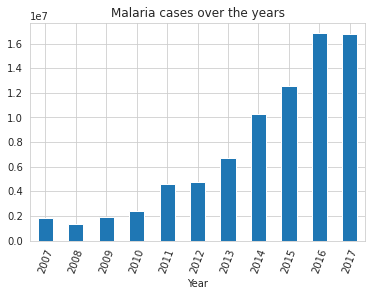

In [ ]:
# malaria cases over the years
max_cases.plot.bar(x="Year", y="Malaria cases reported", rot=70, title="Malaria cases over the years");

plt.show(block=True);

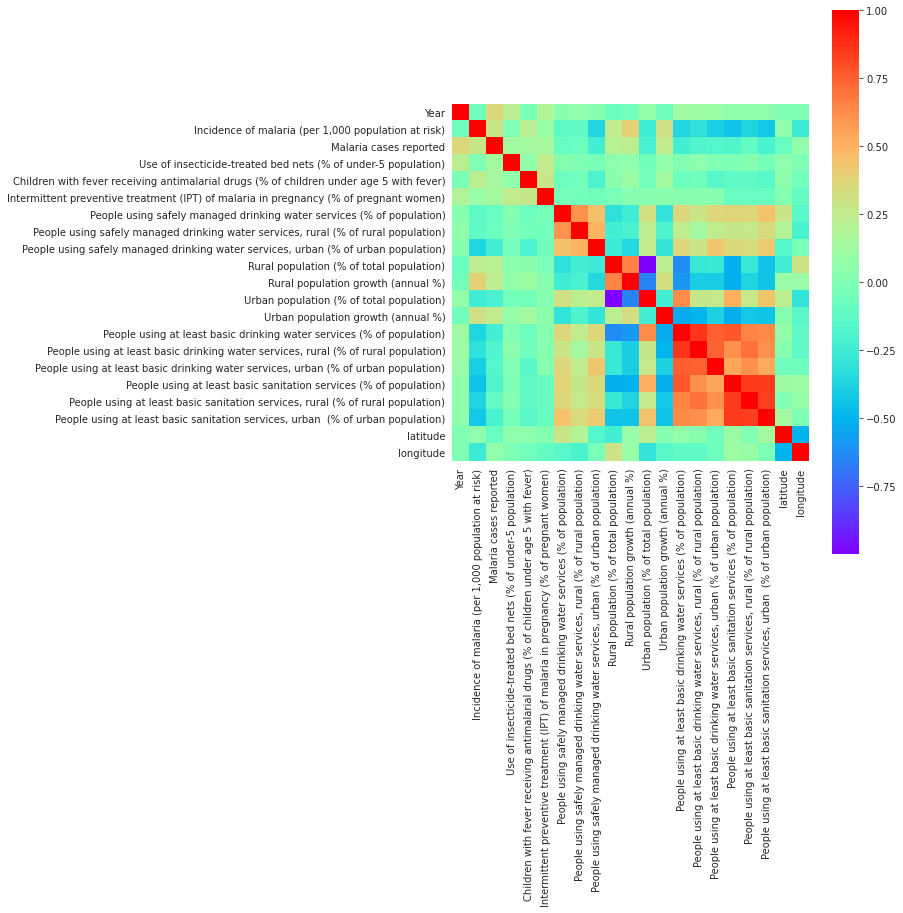

In [ ]:
#checking for correlation
corr = df.corr()
plt.figure(figsize=(8, 10))
sns.heatmap(corr, square=True, annot=False, cmap='rainbow')

In [ ]:
df.head()

,Country Name,Year,Country Code,"Incidence of malaria (per 1,000 population at risk)",Malaria cases reported,Use of insecticide-treated bed nets (% of under-5 population),Children with fever receiving antimalarial drugs (% of children under age 5 with fever),Intermittent preventive treatment (IPT) of malaria in pregnancy (% of pregnant women),People using safely managed drinking water services (% of population),"People using safely managed drinking water services, rural (% of rural population)","People using safely managed drinking water services, urban (% of urban population)",Rural population (% of total population),Rural population growth (annual %),Urban population (% of total population),Urban population growth (annual %),People using at least basic drinking water services (% of population),"People using at least basic drinking water services, rural (% of rural population)","People using at least basic drinking water services, urban (% of urban population)",People using at least basic sanitation services (% of population),"People using at least basic sanitation services, rural (% of rural population)","People using at least basic sanitation services, urban (% of urban population)",latitude,longitude
0,Algeria,2007,DZA,0.01,26.0,42.9,29.3,11.5,28.39,10.675,51.365,34.65,-0.60,65.35,2.71,91.68,85.83,94.78,85.85,76.94,90.57,28.033886,1.659626
1,Angola,2007,AGO,286.72,1533485.0,18.0,29.8,1.5,28.39,10.675,51.365,42.48,1.91,57.52,5.01,47.96,23.77,65.83,37.26,14.00,54.44,-11.202692,17.873887
2,Benin,2007,BEN,480.24,0.0,42.9,29.3,11.5,28.39,10.675,51.365,58.44,1.99,41.56,4.09,63.78,54.92,76.24,11.80,4.29,22.36,9.307690,2.315834
3,Botswana,2007,BWA,1.03,390.0,42.9,29.3,11.5,28.39,10.675,83.960,42.07,-1.44,57.93,4.80,78.89,57.60,94.35,61.60,39.99,77.30,-22.328474,24.684866
4,Burkina Faso,2007,BFA,503.80,44246.0,42.9,29.3,11.5,28.39,10.675,51.365,77.00,2.16,23.00,5.91,52.27,45.13,76.15,15.60,6.38,46.49,12.238333,-1.561593


In [ ]:
#handling the non numerical data
# iterate through the columns
def Nandata(df):
    columns = df.columns.values
    for column in columns:
      # conveerting the columns to alist of it's values and obtain unique values from the set
        mixedvals = {}
        def intconversion(val):
            return mixedvals[val]

        if df[column].dtype != np.int64 and df[column].dtype != np.float64:
            column_values= df[column].values.tolist()
            unique_values = set(column_values)
            z= 0
            for i in unique_values:
                if i not in mixedvals:
                    mixedvals[i] = z
                    z+=1

            df[column] = list(map(intconversion, df[column]))

    return df

df = Nandata(df)
print(df.head())

   Country Name  Year  ...   latitude  longitude
0             7  2007  ...  28.033886   1.659626
1             9  2007  ... -11.202692  17.873887
2            14  2007  ...   9.307690   2.315834
3            50  2007  ... -22.328474  24.684866
4             1  2007  ...  12.238333  -1.561593

[5 rows x 23 columns]


In [ ]:
# defining the attribute we are trying to predict
# use numpy to create two arrays for the features and label
predict = 'Incidence of malaria (per 1,000 population at risk)'
# features
x = np.array(df.drop([predict],1))
# labels
y = np.array(df[predict])

Text(0, 0.5, 'Columns')

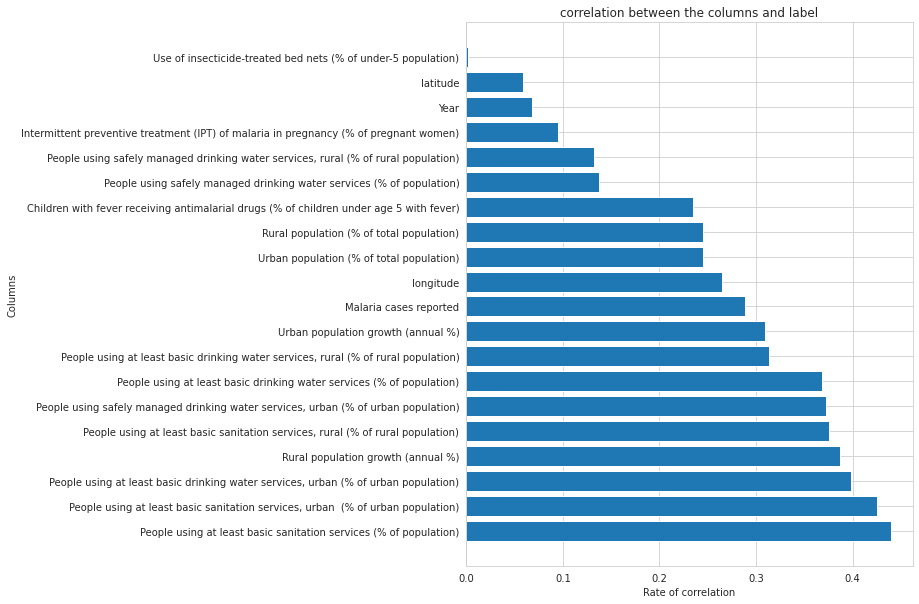

In [ ]:
#checking how columns correlate with the label
labelCorr = abs(corr['Incidence of malaria (per 1,000 population at risk)']).sort_values(ascending=False).drop(['Incidence of malaria (per 1,000 population at risk)'], axis=0)
sns.set_style("whitegrid")
plt.figure(figsize=(8, 10))
plt.title("correlation between the columns and label")
plt.barh(labelCorr.index, labelCorr)
plt.xlabel("Rate of correlation")
plt.ylabel("Columns")

In [ ]:
# dropping the unecessary columns and selecting the ones that are useful
# reason we did trimming rather than dropping is because we have very many useless columns compared to useful ones
df = df[['People using at least basic sanitation services (% of population)','Rural population (% of total population)','People using safely managed drinking water services (% of population)','People using safely managed drinking water services, rural (% of rural population)','Children with fever receiving antimalarial drugs (% of children under age 5 with fever)']]

In [ ]:
# splitting our data into train and test data
x_train,x_test,y_train,y_test = sklearn.model_selection.train_test_split(x,y,test_size = 0.1)

In [ ]:
# defining the model that we are going to use
model = linear_model.LinearRegression()

In [ ]:
df.head()

,People using at least basic sanitation services (% of population),Rural population (% of total population),People using safely managed drinking water services (% of population),"People using safely managed drinking water services, rural (% of rural population)",Children with fever receiving antimalarial drugs (% of children under age 5 with fever)
0,85.85,34.65,28.39,10.675,29.3
1,37.26,42.48,28.39,10.675,29.8
2,11.80,58.44,28.39,10.675,29.3
3,61.60,42.07,28.39,10.675,29.3
4,15.60,77.00,28.39,10.675,29.3


In [ ]:
df = df.dropna()

In [ ]:
x = pd.DataFrame(x)
x.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,7.0,2007.0,24.0,26.0,42.9,29.3,11.5,28.39,10.675,51.365,34.65,-0.60,65.35,2.71,91.68,85.83,94.78,85.85,76.94,90.57,28.033886,1.659626
1,9.0,2007.0,37.0,1533485.0,18.0,29.8,1.5,28.39,10.675,51.365,42.48,1.91,57.52,5.01,47.96,23.77,65.83,37.26,14.00,54.44,-11.202692,17.873887
2,14.0,2007.0,35.0,0.0,42.9,29.3,11.5,28.39,10.675,51.365,58.44,1.99,41.56,4.09,63.78,54.92,76.24,11.80,4.29,22.36,9.307690,2.315834
3,50.0,2007.0,32.0,390.0,42.9,29.3,11.5,28.39,10.675,83.960,42.07,-1.44,57.93,4.80,78.89,57.60,94.35,61.60,39.99,77.30,-22.328474,24.684866
4,1.0,2007.0,16.0,44246.0,42.9,29.3,11.5,28.39,10.675,51.365,77.00,2.16,23.00,5.91,52.27,45.13,76.15,15.60,6.38,46.49,12.238333,-1.561593


In [ ]:
x = x.drop([0,2],axis = 1)

In [ ]:
y = pd.DataFrame(y,columns=['Actual_value'])
y.head()

,Actual_value
0,0.01
1,286.72
2,480.24
3,1.03
4,503.80


In [ ]:
# using xgboost regression
model = XGBRegressor()
model.fit(x_train,y_train)

[08:26:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
# train our model and check for accuracy
model.fit(x_train, y_train)
accuracy = model.score(x_test,y_test)
print(accuracy)

[08:26:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.9558271927328642


In [ ]:
# printing out the test data and checking how the algorithim works in specific cases with the first value being the predicted and the last being t
#the actual value
predictions = model.predict(x_test)

for x in range(len(predictions)):
    print(predictions[x], x_test[x], y_test[x])

277.6671 [3.9000000e+01 2.0070000e+03 1.8000000e+01 6.2870000e+03 4.2900000e+01
 2.9300000e+01 1.1500000e+01 2.8390000e+01 1.0675000e+01 5.1365000e+01
 3.8900000e+01 4.3000000e-01 6.1100000e+01 7.4000000e+00 5.7120000e+01
 3.4430000e+01 7.1560000e+01 6.1320000e+01 5.1850000e+01 6.7350000e+01
 1.6508010e+00 1.0267895e+01] 398.15
179.33238 [ 6.0000000e+00  2.0140000e+03  4.3000000e+01  6.8044200e+05
  4.2900000e+01  2.9300000e+01  1.1500000e+01  2.8390000e+01
  1.0675000e+01  3.3720000e+01  6.9100000e+01  1.9800000e+00
  3.0900000e+01  5.3200000e+00  5.1120000e+01  3.7480000e+01
  8.1620000e+01  2.5350000e+01  2.0090000e+01  3.7110000e+01
 -6.3690280e+00  3.4888822e+01] 118.94
112.89383 [5.2000000e+01 2.0080000e+03 7.0000000e+00 4.5856100e+05 4.2900000e+01
 2.9300000e+01 1.1500000e+01 7.0300000e+00 1.1700000e+00 3.6630000e+01
 8.3490000e+01 2.2700000e+00 1.6510000e+01 5.1600000e+00 3.0370000e+01
 2.0820000e+01 7.8630000e+01 5.2300000e+00 2.7700000e+00 1.7690000e+01
 9.1450000e+00 4.04896

In [ ]:
predicted = pd.DataFrame(model.predict(x_test), columns= ['predicted'])
predicted.head()

,predicted
0,277.667114
1,179.332382
2,112.893829
3,151.205399
4,386.727509
